In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data as data
from tensorboard import summary
from torch.autograd import Variable
import torch.optim as optim
from PIL import Image
import PIL
import os
import os.path
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dateutil
import dateutil.tz
import errno
import torch.backends.cudnn as cudnn
import time
import torchvision.utils as vutils
from tqdm import tqdm

In [19]:
STAGE=1
CUDA=True
GPU_ID = '0'
DATA_DIR = '/kaggle/input/'
BATCH_SIZE=64
GF_DIM=128
DF_DIM=64
CONDITION_DIM = 128
Z_DIM = 100
TEXT_DIMENSION = 1024
KL=2.0
NET_G='/kaggle/input/stackgan/pytorch/generator/1/netG_epoch_100.pth'
NET_D='/kaggle/input/stackgan/pytorch/discriminator/1/netD_epoch_last.pth'
DISCRIMINATOR_LR=0.0002
GENERATOR_LR=0.0002
SNAPSHOT_INTERVAL=2
VIS_COUNT=64
NET2_G='/kaggle/input/stackgan-stage2/pytorch/gan/1/netG_epoch_10.pth'
NET2_D='/kaggle/input/stackgan-stage2/pytorch/gan/1/netD_epoch_last.pth'
R_NUM = 4


random.seed(42)
torch.manual_seed(42)

In [3]:
class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train', imsize=64,stage=1):
        self.imsize = imsize
        self.data = []
        self.data_dir = data_dir
        self.split=split
        self.bbox = self.load_bbox()
        if stage==1:
            self.images,self.embeddings=self.load_data()
        else:
            self.images,self.embeddings=self.load_stage2_data()

    def get_img(self, img_path, bbox):
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        img_size=self.imsize
        if bbox is not None:
            R = int(np.maximum(bbox[2], bbox[3]) * 0.5)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        img = img.resize((img_size, img_size), PIL.Image.BILINEAR)
        return img

    def load_bbox(self):
        dataset_dir = self.data_dir
        filename_bb_dict={}
        classes=['dresses','jackets and coats','jeans','pants','shirts','shorts','skirts','suits and blazers','sweaters','tops']
        for i in range(10):
#         print(classes[i])
            bounding_boxes_path = os.path.join(dataset_dir, f'bounding-boxes/bb-{self.split}/bb-{self.split}/bb-{classes[i]}.txt')
            class_bb_dict={}
            df_bounding_boxes = pd.read_csv(bounding_boxes_path,delim_whitespace=True, header=None)
    #         print(df_bounding_boxes[df_bounding_boxes.isnull().any(axis=1)])
            class_bb_dict = {f'{classes[i]}-image{j}': df_bounding_boxes.iloc[j][1:].tolist() for j in range(df_bounding_boxes.shape[0])}
            filename_bb_dict={**filename_bb_dict,**class_bb_dict}
    #     print(filename_bb_dict)
       
        return filename_bb_dict


    def load_embeddings(self, embeddings_file_path):
        with open(embeddings_file_path, 'rb') as f:
            embeddings = pickle.load(f)
#         embeddings = np.array(embeddings)
#         print('embeddings: ', embeddings)
        return embeddings   

    def load_data(self):
        with open(f'/kaggle/input/model-data2/kaggle/working/data/{self.split}-data.pickle','rb') as f:
            x,y,embeddings=pickle.load(f)
        f.close()
        x=np.transpose(x,(0, 3, 1, 2))
        return x,embeddings
    
    def load_stage2_data(self):
        img_data,embeddings=np.empty((4161+13927+6032+10811+5500+3559+3304+1680+12000+15000,256,256,3),dtype=np.uint8),np.empty((4161+13927+6032+10811+5500+3559+3304+1680+12000+15000,1024),dtype=np.float32)
        bounding_boxes=self.load_bbox()
        embeddings_file_path='/kaggle/input/fashiongen-utils/embeddings-single.pickle' if self.split=='train' else '/kaggle/input/fashiongen-utils/embeddings-single-val.pickle'
        all_embeddings=self.load_embeddings(embeddings_file_path)
        classes={'dresses': 4161, 'jackets and coats': 13927, 'jeans': 6032, 'pants': 10811, 'shirts': 5500, 'shorts': 3559, 'skirts': 3304, 'suits and blazers': 1680, 'sweaters': 12000, 'tops': 15000}
        count=0
        for index,key in enumerate(classes.keys()):
            print(index,key)
            for i in range(classes[key]):
                if(i%1000==0):
                    print(key,i)
                bounding_box = bounding_boxes[f'{key}-image{i}']
                img_name = f'/kaggle/input/raw-images/raw-images/{self.split}/{key}/{key}-image{i}.jpg'
                img = self.get_img(img_name,bounding_box)
                embedding = all_embeddings[index][i]
                img=np.array(img,dtype=np.uint8)
                img_data[count]=img
                embeddings[count]=embedding
                count+=1
        
        img_data=np.transpose(img_data,(0,3,1,2))
        return img_data,embeddings
            

    def __getitem__(self, index):        
        img=self.images[index]
        embedding=self.embeddings[index]
        return img, embedding

    def __len__(self):
        return len(self.images)

In [4]:
def KL_loss(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD

def compute_discriminator_loss(netD, real_imgs, fake_imgs,
                               real_labels, fake_labels,
                               conditions, gpus):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = conditions.detach()
    fake = fake_imgs.detach()
    real_features = nn.parallel.data_parallel(netD, (real_imgs), gpus)
    fake_features = nn.parallel.data_parallel(netD, (fake), gpus)
    # real pairs
    inputs = (real_features, cond)
    real_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_real = criterion(real_logits, real_labels)
    # wrong pairs
    inputs = (real_features[:(batch_size-1)], cond[1:])
    wrong_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_wrong = criterion(wrong_logits, fake_labels[1:])
    # fake pairs
    inputs = (fake_features, cond)
    fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_fake = criterion(fake_logits, fake_labels)

    if netD.get_uncond_logits is not None:
        real_logits = nn.parallel.data_parallel(netD.get_uncond_logits,(real_features), gpus)
        fake_logits = nn.parallel.data_parallel(netD.get_uncond_logits,(fake_features), gpus)
        uncond_errD_real = criterion(real_logits, real_labels)
        uncond_errD_fake = criterion(fake_logits, fake_labels)
        #
        errD = ((errD_real + uncond_errD_real) / 2. +
                (errD_fake + errD_wrong + uncond_errD_fake) / 3.)
        errD_real = (errD_real + uncond_errD_real) / 2.
        errD_fake = (errD_fake + uncond_errD_fake) / 2.
    else:
        errD = errD_real + (errD_fake + errD_wrong) * 0.5
    #return errD, errD_real.data[0], errD_wrong.data[0], errD_fake.data[0]
    return errD, errD_real.data, errD_wrong.data, errD_fake.data


def compute_generator_loss(netD, fake_imgs, real_labels, conditions, gpus):
    criterion = nn.BCELoss()
    cond = conditions.detach()
    fake_features = nn.parallel.data_parallel(netD, (fake_imgs), gpus)
    # fake pairs
    inputs = (fake_features, cond)
    fake_logits = nn.parallel.data_parallel(netD.get_cond_logits, inputs, gpus)
    errD_fake = criterion(fake_logits, real_labels)
    if netD.get_uncond_logits is not None:
        fake_logits = \
            nn.parallel.data_parallel(netD.get_uncond_logits,
                                      (fake_features), gpus)
        uncond_errD_fake = criterion(fake_logits, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake


#############################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


#############################
def save_img_results(data_img, fake, epoch, image_dir):
    num = VIS_COUNT
    fake = fake[0:num]
    # data_img is changed to [0,1]
    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(
            data_img, '%s/real_samples.png' % image_dir,
            normalize=True)
        # fake.data is still [-1, 1]
        vutils.save_image(
            fake.data, '%s/fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)
    else:
        vutils.save_image(
            fake.data, '%s/lr_fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)


def save_model(netG, netD, epoch, model_dir):
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    print('Save G/D models')


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True))
    return block

In [6]:
class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num),
            nn.ReLU(True),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out


In [7]:
class CA_NET(nn.Module):

    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = TEXT_DIMENSION
        self.c_dim = CONDITION_DIM
        self.fc = nn.Linear(self.t_dim, self.c_dim * 2, bias=True)
        self.relu = nn.ReLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.c_dim]
        logvar = x[:, self.c_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if CUDA:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar

In [8]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf, nef, bcondition=True):
        super(D_GET_LOGITS, self).__init__()
        self.df_dim = ndf
        self.ef_dim = nef
        self.bcondition = bcondition
        if bcondition:
            self.outlogits = nn.Sequential(
                conv3x3(ndf * 8 + nef, ndf * 8),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())
        else:
            self.outlogits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, h_code, c_code=None):
        # conditioning output
        if self.bcondition and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((h_code, c_code), 1)
        else:
            h_c_code = h_code

        output = self.outlogits(h_c_code)
        return output.view(-1)

In [23]:
class STAGE1_G(nn.Module):
    def __init__(self):
        super(STAGE1_G, self).__init__()
        self.gf_dim = GF_DIM * 8
        self.ef_dim = CONDITION_DIM
        self.z_dim = Z_DIM
        self.define_module()

    def define_module(self):
        ninput = self.z_dim + self.ef_dim
#         ninput=self.ef_dim
        ngf = self.gf_dim
        self.ca_net = CA_NET()

        # -> ngf x 4 x 4
        self.fc = nn.Sequential(
            nn.Linear(ninput, ngf * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4),
            nn.ReLU(True))

        # ngf x 4 x 4 -> ngf/2 x 8 x 8
        self.upsample1 = upBlock(ngf, ngf // 2)
        # -> ngf/4 x 16 x 16
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        # -> ngf/8 x 32 x 32
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        # -> ngf/16 x 64 x 64
        self.upsample4 = upBlock(ngf // 8, ngf // 16)
        # -> 3 x 64 x 64
        self.img = nn.Sequential(
            conv3x3(ngf // 16, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        c_code, mu, logvar = self.ca_net(text_embedding)
        z_c_code = torch.cat((noise, c_code), 1)
#         z_c_code=c_code
        h_code = self.fc(z_c_code)

        h_code = h_code.view(-1, self.gf_dim, 4, 4)
        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)
        # state size 3 x 64 x 64
        fake_img = self.img(h_code)
        return None, fake_img, mu, logvar

In [10]:
class STAGE1_D(nn.Module):
    def __init__(self):
        super(STAGE1_D, self).__init__()
        self.df_dim = DF_DIM
        self.ef_dim = CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # state size (ndf * 8) x 4 x 4)
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef)
        self.get_uncond_logits = None

    def forward(self, image):
        img_embedding = self.encode_img(image)
        return img_embedding

In [11]:
class STAGE2_G(nn.Module):
    def __init__(self, STAGE1_G):
        super(STAGE2_G, self).__init__()
        self.gf_dim = GF_DIM
        self.ef_dim = CONDITION_DIM
        self.z_dim = Z_DIM
        self.STAGE1_G = STAGE1_G
        # fix parameters of stageI GAN
        for param in self.STAGE1_G.parameters():
            param.requires_grad = False
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(R_NUM):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        # TEXT.DIMENSION -> GAN.CONDITION_DIM
        self.ca_net = CA_NET()
        # --> 4ngf x 16 x 16
        self.encoder = nn.Sequential(
            conv3x3(3, ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.hr_joint = nn.Sequential(
            conv3x3(self.ef_dim + ngf * 4, ngf * 4),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True))
        self.residual = self._make_layer(ResBlock, ngf * 4)
        # --> 2ngf x 32 x 32
        self.upsample1 = upBlock(ngf * 4, ngf * 2)
        # --> ngf x 64 x 64
        self.upsample2 = upBlock(ngf * 2, ngf)
        # --> ngf // 2 x 128 x 128
        self.upsample3 = upBlock(ngf, ngf // 2)
        # --> ngf // 4 x 256 x 256
        self.upsample4 = upBlock(ngf // 2, ngf // 4)
        # --> 3 x 256 x 256
        self.img = nn.Sequential(
            conv3x3(ngf // 4, 3),
            nn.Tanh())

    def forward(self, text_embedding, noise):
        _, stage1_img, _, _ = self.STAGE1_G(text_embedding, noise)
        stage1_img = stage1_img.detach()
        encoded_img = self.encoder(stage1_img)

        c_code, mu, logvar = self.ca_net(text_embedding)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, 16, 16)
        i_c_code = torch.cat([encoded_img, c_code], 1)
        h_code = self.hr_joint(i_c_code)
        h_code = self.residual(h_code)

        h_code = self.upsample1(h_code)
        h_code = self.upsample2(h_code)
        h_code = self.upsample3(h_code)
        h_code = self.upsample4(h_code)

        fake_img = self.img(h_code)
        return stage1_img, fake_img, mu, logvar

In [12]:
class STAGE2_D(nn.Module):
    def __init__(self):
        super(STAGE2_D, self).__init__()
        self.df_dim = DF_DIM
        self.ef_dim = CONDITION_DIM
        self.define_module()

    def define_module(self):
        ndf, nef = self.df_dim, self.ef_dim
        self.encode_img = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),  # 128 * 128 * ndf
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # 64 * 64 * ndf * 2
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # 32 * 32 * ndf * 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # 16 * 16 * ndf * 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),  # 8 * 8 * ndf * 16
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),  # 4 * 4 * ndf * 32
            conv3x3(ndf * 32, ndf * 16),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),   # 4 * 4 * ndf * 16
            conv3x3(ndf * 16, ndf * 8),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)   # 4 * 4 * ndf * 8
        )

        self.get_cond_logits = D_GET_LOGITS(ndf, nef, bcondition=True)
        self.get_uncond_logits = D_GET_LOGITS(ndf, nef, bcondition=False)

    def forward(self, image):
        img_embedding = self.encode_img(image)
        return img_embedding

In [13]:
class GANTrainer(object):
    def __init__(self, output_dir,train):
        if train:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            self.log_dir = os.path.join(output_dir, 'Log')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)
            mkdir_p(self.log_dir)

        self.max_epoch = 100
        self.snapshot_interval = SNAPSHOT_INTERVAL

        s_gpus = GPU_ID.split(',')
        self.gpus = [int(ix) for ix in s_gpus]
        self.num_gpus = len(self.gpus)
        self.batch_size = BATCH_SIZE * self.num_gpus
        torch.cuda.set_device(self.gpus[0])
        cudnn.benchmark = True

    # ############# For training stageI GAN #############
    def load_network_stageI(self):
        netG = STAGE1_G()
        netG.apply(weights_init)
        netD = STAGE1_D()
        netD.apply(weights_init)
        print(netD)

        if NET_G != '':
            state_dict = torch.load(NET_G,map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load from: ', NET_G)
        if NET_D != '':
            state_dict = torch.load(NET_D,map_location=lambda storage, loc: storage)
            netD.load_state_dict(state_dict)
            print('Load from: ', NET_D)
        if CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD

    # ############# For training stageII GAN  #############
    def load_network_stageII(self):

        Stage1_G = STAGE1_G()
        netG = STAGE2_G(Stage1_G)
        netG.apply(weights_init)
        print(netG)
        if NET2_G != '':
            state_dict = torch.load(NET2_G,map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load from: ', NET_G)
        elif NET_G != '':
            state_dict = torch.load(NET_G,map_location=lambda storage, loc: storage)
            netG.STAGE1_G.load_state_dict(state_dict)
            print('Load from: ', NET_G)
        else:
            print("Please give the Stage1_G path")
            return

        netD = STAGE2_D()
        netD.apply(weights_init)
        if NET2_D != '':
            state_dict = torch.load(NET2_D,map_location=lambda storage, loc: storage)
            netD.load_state_dict(state_dict)
            print('Load from: ', NET2_D)
        print(netD)

        if CUDA:
            netG.cuda()
            netD.cuda()
        return netG, netD

    def train(self, data_loader,stage):
        if stage == 1:
            netG, netD = self.load_network_stageI()
        else:
            netG, netD = self.load_network_stageII()
        nz = Z_DIM
        batch_size = self.batch_size
        noise = Variable(torch.FloatTensor(batch_size, nz))
        fixed_noise = Variable(torch.FloatTensor(batch_size, nz).normal_(0, 1),volatile=True)
        real_labels = Variable(torch.FloatTensor(batch_size).fill_(1))
        fake_labels = Variable(torch.FloatTensor(batch_size).fill_(0))
        if CUDA:
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
            real_labels, fake_labels = real_labels.cuda(), fake_labels.cuda()
        generator_lr = GENERATOR_LR
        discriminator_lr = DISCRIMINATOR_LR
#         lr_decay_step = LR_DECAY_EPOCH
        optimizerD = optim.Adam(netD.parameters(),lr=DISCRIMINATOR_LR, betas=(0.5, 0.999))
        netG_para = []
        for p in netG.parameters():
            if p.requires_grad:
                netG_para.append(p)
        optimizerG = optim.Adam(netG_para,lr=GENERATOR_LR,betas=(0.5, 0.999))
        count = 0
        for epoch in range(self.max_epoch):
            start_t = time.time()
            for i, data in enumerate(tqdm(data_loader)):
                ######################################################
                # (1) Prepare training data
                ######################################################
                real_img_cpu, txt_embedding = data
                real_img_cpu=(real_img_cpu-127.5)/127.5
                real_imgs = Variable(real_img_cpu)
                txt_embedding = Variable(txt_embedding)
                if CUDA:
                    real_imgs = real_imgs.cuda()
                    txt_embedding = txt_embedding.cuda()

                #######################################################
                # (2) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                inputs = (txt_embedding, noise)
                _, fake_imgs, mu, logvar = nn.parallel.data_parallel(netG, inputs, self.gpus)

                ############################
                # (3) Update D network
                ###########################
                netD.zero_grad()
                errD, errD_real, errD_wrong, errD_fake = compute_discriminator_loss(netD, real_imgs, fake_imgs,
                                               real_labels, fake_labels,
                                               mu, self.gpus)
                errD.backward()
                optimizerD.step()
                ############################
                # (2) Update G network
                ###########################
                netG.zero_grad()
                errG = compute_generator_loss(netD, fake_imgs,
                                              real_labels, mu, self.gpus)
                kl_loss = KL_loss(mu, logvar)
                errG_total = errG + kl_loss * KL
                errG_total.backward()
                optimizerG.step()

                count = count + 1
                if i % 100 == 0:
                    # save the image result for each epoch
                    inputs = (txt_embedding, fixed_noise)
                    lr_fake, fake, _, _ = nn.parallel.data_parallel(netG, inputs, self.gpus)
                    save_img_results(real_img_cpu, fake, epoch, self.image_dir)
                    if lr_fake is not None:
                        save_img_results(None, lr_fake, epoch, self.image_dir)
            end_t = time.time()
            print('''[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f Loss_KL: %.4f
                     Loss_real: %.4f Loss_wrong:%.4f Loss_fake %.4f
                     Total Time: %.2fsec
                  '''
                  % (epoch, self.max_epoch, i, len(data_loader),
                     errD.data, errG.data, kl_loss.data,
                     errD_real, errD_wrong, errD_fake, (end_t - start_t)))
            if epoch % self.snapshot_interval == 0:
                save_model(netG, netD, epoch, self.model_dir)
        #
        save_model(netG, netD, self.max_epoch, self.model_dir)
        #

    def sample(self, datapath, stage):
        if stage == 1:
            netG, _ = self.load_network_stageI()
        else:
            netG, _ = self.load_network_stageII()
        netG.eval()
        # Load text embeddings generated from the encoder
        with open(datapath,'rb') as f:
            xtest,_,embeddings = pickle.load(f)
#         captions_list = t_file.raw_txt
#         embeddings = np.concatenate(t_file, axis=0)
        num_embeddings = len(embeddings)
        print('Successfully load sentences from: ', datapath)
        print('Total number of sentences:', num_embeddings)
        print('num_embeddings:', num_embeddings, embeddings.shape)
        # path to save generated samples
        save_dir = NET_G[:NET_G.find('.pth')]
        mkdir_p(save_dir)

        batch_size = np.minimum(num_embeddings, self.batch_size)
        nz = Z_DIM
        noise = Variable(torch.FloatTensor(batch_size, nz))
        if CUDA:
            noise = noise.cuda()
        count = 0
        while count < num_embeddings:
            if count > 3000:
                break
            iend = count + batch_size
            if iend > num_embeddings:
                iend = num_embeddings
                count = num_embeddings - batch_size
            embeddings_batch = embeddings[count:iend]
            # captions_batch = captions_list[count:iend]
            txt_embedding = Variable(torch.FloatTensor(embeddings_batch))
            if CUDA:
                txt_embedding = txt_embedding.cuda()

            #######################################################
            # (2) Generate fake images
            ######################################################
            noise.data.normal_(0, 1)
            inputs = (txt_embedding, noise)
            _, fake_imgs, mu, logvar = \
                nn.parallel.data_parallel(netG, inputs, self.gpus)
            for i in tqdm(range(batch_size)):
                #save_name = '%s/%d.png' % (save_dir, count + i)
                save_name = f'image-{i}.jpg'
                im = fake_imgs[i].data.cpu().numpy()
                im = (im + 1.0) * 127.5
                im = im.astype(np.uint8)
                # print('im', im.shape)
                im = np.transpose(im, (1, 2, 0))
                # print('im', im.shape)
                im = Image.fromarray(im)
                im.save(save_name)
            count += batch_size
            
    def test(self,embedding,stage):
        if stage == 1:
            netG, _ = self.load_network_stageI()
        else:
            netG, _ = self.load_network_stageII()
        netG.eval()
        nz=Z_DIM
        noise = Variable(torch.FloatTensor(1,nz))
        txt_embedding = Variable(torch.FloatTensor(embedding)).unsqueeze(0)
        if CUDA:
            noise = noise.cuda()
        if CUDA:
            txt_embedding = txt_embedding.cuda()
        noise.data.normal_(0, 1)
        inputs=(txt_embedding, noise)
        _, fake_img, mu, logvar = nn.parallel.data_parallel(netG, inputs, self.gpus)
        im = fake_img.data.cpu().numpy()
        im = (im + 1.0) * 127.5
        im = im.astype(np.uint8)
        im = im.squeeze(0)
        im = np.transpose(im, (1, 2, 0))
        im = Image.fromarray(im)
#         im.save('/kaggle/working/kaggle/working/testImg.jpg')
        plt.imshow(im)

In [24]:
if CUDA:
    torch.cuda.manual_seed_all(42)
now = datetime.datetime.now(dateutil.tz.tzlocal())
timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
output_dir = 'kaggle/working/'

num_gpu = len(GPU_ID.split(','))
dataset = TextDataset(DATA_DIR, 'train',imsize=256,stage=2)
dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=BATCH_SIZE * num_gpu,
            drop_last=True, shuffle=True)

algo = GANTrainer(output_dir,True)

# algo.sample('/kaggle/input/model-data2/kaggle/working/data/test-data.pickle')

/tmp/ipykernel_34/2410843730.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,delim_whitespace=True, header=None)
/tmp/ipykernel_34/2410843730.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,delim_whitespace=True, header=None)
/tmp/ipykernel_34/2410843730.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxes = pd.read_csv(bounding_boxes_path,delim_whitespace=True, header=None)
/tmp/ipykernel_34/2410843730.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bounding_boxe

0 dresses
dresses 0


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/raw-images/raw-images/train/dresses/dresses-image0.jpg'

In [ ]:
algo.train(dataloader,stage=1)

In [15]:
def load_single_embedding(embeddings_file_path,i,j):
    with open(embeddings_file_path, 'rb') as f:
        embeddings = pickle.load(f)
#         embeddings = np.array(embeddings)
#         print('embeddings: ', embeddings)
    return embeddings[i][j] 

STAGE2_G(
  (STAGE1_G): STAGE1_G(
    (ca_net): CA_NET(
      (fc): Linear(in_features=1024, out_features=256, bias=True)
      (relu): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=228, out_features=16384, bias=False)
      (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (upsample3): Sequential

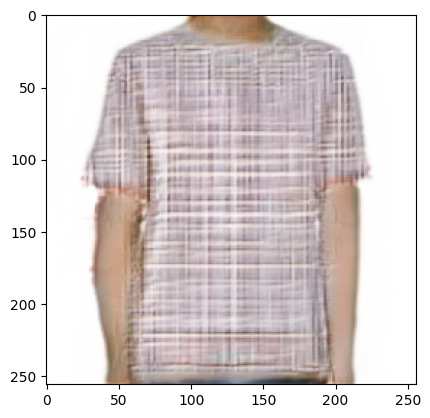

In [47]:
emb=load_single_embedding('/kaggle/input/fashiongen-utils/embeddings-single-val.pickle',7,56)
algo.test(emb,stage=2)

In [19]:
with open('/kaggle/input/fashiongen-utils/model.pickle','rb') as f:
    model=pickle.load(f)
    
model.eval()

AttributeError: Can't get attribute 'char_cnn_rnn' on <module '__main__'>